# RNN, LSTM, GRU의 주가 예측 모델의 성능 비교 테스트

In [49]:
import pandas as pd

df = pd.read_csv("../dataset/AAPL_2006-01-01_to_2018-01-01.csv")

df.head(5)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [50]:
sample_x = df["Close"]
sample_y = df["Date"]

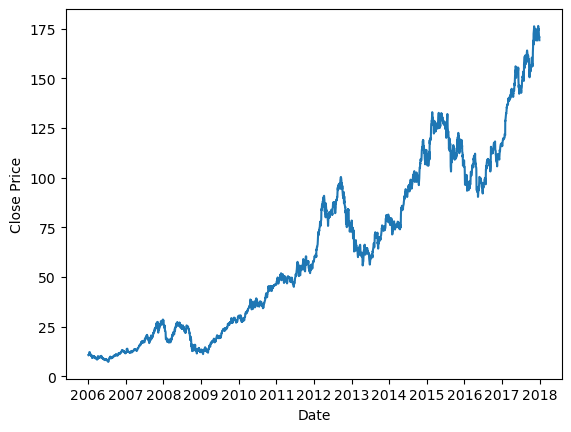

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from datetime import datetime

date = []

for row in sample_y:
    date.append(matplotlib.dates.date2num(datetime.strptime(row, '%Y-%m-%d')))

plt.plot(date, sample_x.to_numpy())
plt.xlabel("Date")
plt.ylabel("Close Price")

ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.show()

In [52]:
def show_stock_graph(prices):
    plt.plot(date, prices)
    plt.xlabel("Date")
    plt.ylabel("Close Price")

    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    plt.show()

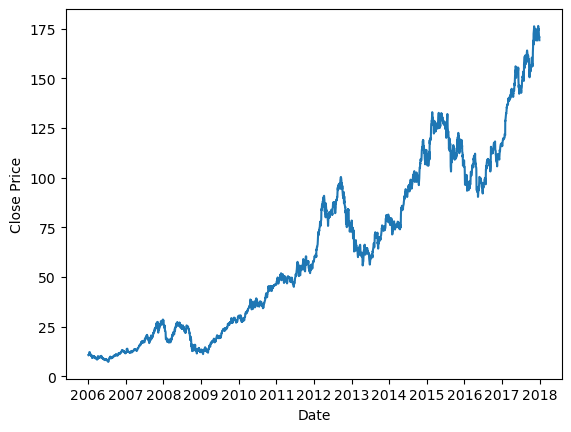

In [53]:
show_stock_graph(sample_x.to_numpy())

## 1. 종가만 가지고 예측을 진행하기

In [54]:
import numpy as np

def split_data(stock, lookback):
    data_row = stock.to_numpy()
    data = []

    for index in range(len(data_row) - lookback):
        data.append(data_row[index:index+lookback])
    
    data = np.array(data)

    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]

    return [x_train, y_train, x_test, y_test]


In [55]:
lookback = 20
price = df["Close"]
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [56]:
x_train[:3], y_train[:3]

(array([[10.68, 10.71, 10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23,
         12.1 , 11.78, 11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29,
         10.71],
        [10.71, 10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23, 12.1 ,
         11.78, 11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29, 10.71,
         10.79],
        [10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23, 12.1 , 11.78,
         11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29, 10.71, 10.79,
         10.77]]),
 array([10.79, 10.77, 10.3 ]))

In [57]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [105]:
input_dim = 1
hidden_dim = 19
num_layers = 2
output_dim = 1
num_epochs = 1000

In [106]:
from torchsummary import summary as summary_

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 10)
        self.batchnorm = nn.BatchNorm1d(10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, output_dim)

    def forward(self, x):
        out, state_ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


model = RNN(input_dim, hidden_dim, num_layers, output_dim)
summary_(model,(19,1),batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 19, 19], [-1, 2, 19]]               0
            Linear-2                   [10, 10]             200
       BatchNorm1d-3                   [10, 10]              20
              ReLU-4                   [10, 10]               0
           Dropout-5                   [10, 10]               0
            Linear-6                    [10, 1]              11
Total params: 231
Trainable params: 231
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.00
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [107]:
import torch.optim as optim

#model = RNN(input_dim, 30, output_dim, num_layers)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [108]:
# x_train = x_train.squeeze(0)
# print(x_train.shape)
x_train_rnn = x_train.unsqueeze(2)
print(x_train_rnn.shape)

y_train_rnn_ = y_train_rnn.unsqueeze(1)
print(y_train_rnn_.shape)


torch.Size([2399, 19, 1])
torch.Size([2399, 1])


In [109]:
import matplotlib.gridspec as gridspec

hist = []

for epoch in range(num_epochs):
    y_train_pred = model(x_train_rnn)

    optimizer.zero_grad()
    loss = criterion(y_train_pred, y_train_rnn_)
    print(f"Epoch: [{epoch}/{num_epochs}] | Loss: {loss.item()}")
    
    hist.append(loss.item())

    loss.backward()
    optimizer.step()


Epoch: [0/1000] | Loss: 3642.4619140625
Epoch: [1/1000] | Loss: 3614.6953125
Epoch: [2/1000] | Loss: 3603.197509765625
Epoch: [3/1000] | Loss: 3591.197509765625
Epoch: [4/1000] | Loss: 3583.338134765625
Epoch: [5/1000] | Loss: 3573.4951171875
Epoch: [6/1000] | Loss: 3567.180419921875
Epoch: [7/1000] | Loss: 3564.704833984375
Epoch: [8/1000] | Loss: 3549.918701171875
Epoch: [9/1000] | Loss: 3537.437255859375
Epoch: [10/1000] | Loss: 3527.88671875
Epoch: [11/1000] | Loss: 3517.124755859375
Epoch: [12/1000] | Loss: 3509.78369140625
Epoch: [13/1000] | Loss: 3497.4267578125
Epoch: [14/1000] | Loss: 3488.93994140625
Epoch: [15/1000] | Loss: 3478.95654296875
Epoch: [16/1000] | Loss: 3461.7734375
Epoch: [17/1000] | Loss: 3453.63720703125
Epoch: [18/1000] | Loss: 3439.91162109375
Epoch: [19/1000] | Loss: 3427.037109375
Epoch: [20/1000] | Loss: 3419.912353515625
Epoch: [21/1000] | Loss: 3409.07177734375
Epoch: [22/1000] | Loss: 3395.594970703125
Epoch: [23/1000] | Loss: 3380.36669921875
Epoch: [

In [110]:
def show_history(hist, y, y_pred):
    fig = plt.figure() 

    gs = gridspec.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0,0])
    ax1.plot(y)
    ax1.plot(y_pred)
    ax1.legend()

    # ax1.xlabel("Date")
    # ax1.ylabel("Price") 

    #x_range = np.arange(hist.shape[0])
    ax2 = plt.subplot(gs[0, 1])
    ax2.plot(range(len(hist)), hist)
    # ax2.xlabel("Epoch")
    # ax2.ylabel("Training Loss")

    plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([[  3.9792],
        [  4.2855],
        [  4.0034],
        ...,
        [107.3917],
        [ 90.3984],
        [119.8221]], grad_fn=<AddmmBackward0>)


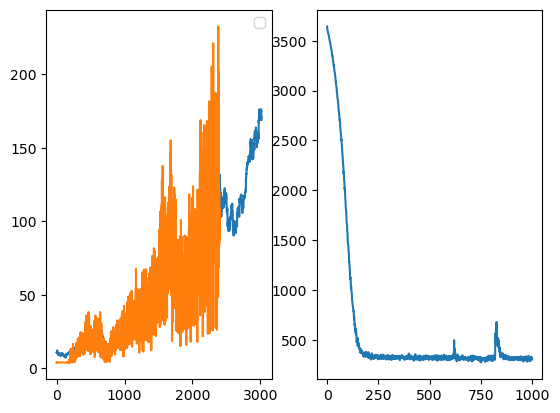

In [111]:

y_finally_pred = model(x_train_rnn)

print(y_finally_pred)

show_history(hist, price.to_numpy(), y_finally_pred.detach().numpy())